In [1]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import utils
warnings.filterwarnings(action='ignore', category=UserWarning)

In [2]:
#Se leen los datos y se seleccionan las variables que presentan una diferencia
# entre los individuos que presentan estres y los que no
data_path = Path(os.getcwd()).parent / "data"
silver_path = data_path / "silver" / "dreadditCleanTrain.csv"
df = pd.read_csv(silver_path, usecols= ["text",
                                        "clean_text",
                                        "singular_pronouns","adj_adv",
                                        "label"])

In [3]:
#Configuracion de visualizaciones 

# Configurar el estilo de fondo con una cuadrícula
sns.set_style("whitegrid")

# Establecer una paleta de colores profesional
sns.set_palette("pastel")

# Configurar la tipografía y el tamaño de la fuente
sns.set_context("paper", font_scale=1.5, rc={"font.family": "sans-serif", "font.sans-serif": ["Helvetica", "Arial"]})

# Desactivar spines innecesarios
sns.despine(trim=True, left=True);

<Figure size 640x480 with 0 Axes>

In [4]:
# Cargar el modelo de SpaCy
nlp = spacy.load('en_core_web_sm')

In [5]:
# se almacenan todos los textos en una lista
texts = df['clean_text'].tolist()

# Procesar los textos en lotes
docs = nlp.pipe(texts)

#### **Preprocesamiento y entrenamiento de modelos**

In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 3), 
                        stop_words='english')

features = tfidf.fit_transform(df["clean_text"]).toarray()


In [8]:
X,y = pd.DataFrame(features),df.label

In [9]:
X['singular_pronouns'] = df['singular_pronouns']
X['adj_adv'] = df['adj_adv']

In [10]:
# Get and evaluate models
models = utils.get_models()
results, names = [], []
for name, model in models.items():
    scores = utils.evaluate_model(model, X.values, y, name, "TFIDF+manuales")
    results.append(scores)
    names.append(name)
    print(f'>{name}: Mean F1 score = {scores.mean():.2f} with Std = {scores.std():.2f}')

>Logistic Regression: Mean F1 score = 0.73 with Std = 0.02
>K-Nearest Neighbors: Mean F1 score = 0.58 with Std = 0.11
>Decision Tree: Mean F1 score = 0.72 with Std = 0.01
>SVM: Mean F1 score = 0.75 with Std = 0.01
>Naive Bayes: Mean F1 score = 0.70 with Std = 0.02
>XGBoost: Mean F1 score = 0.72 with Std = 0.02
>Gradient Boosting: Mean F1 score = 0.72 with Std = 0.01
>Random Forest: Mean F1 score = 0.71 with Std = 0.01
>AdaBoost: Mean F1 score = 0.73 with Std = 0.02


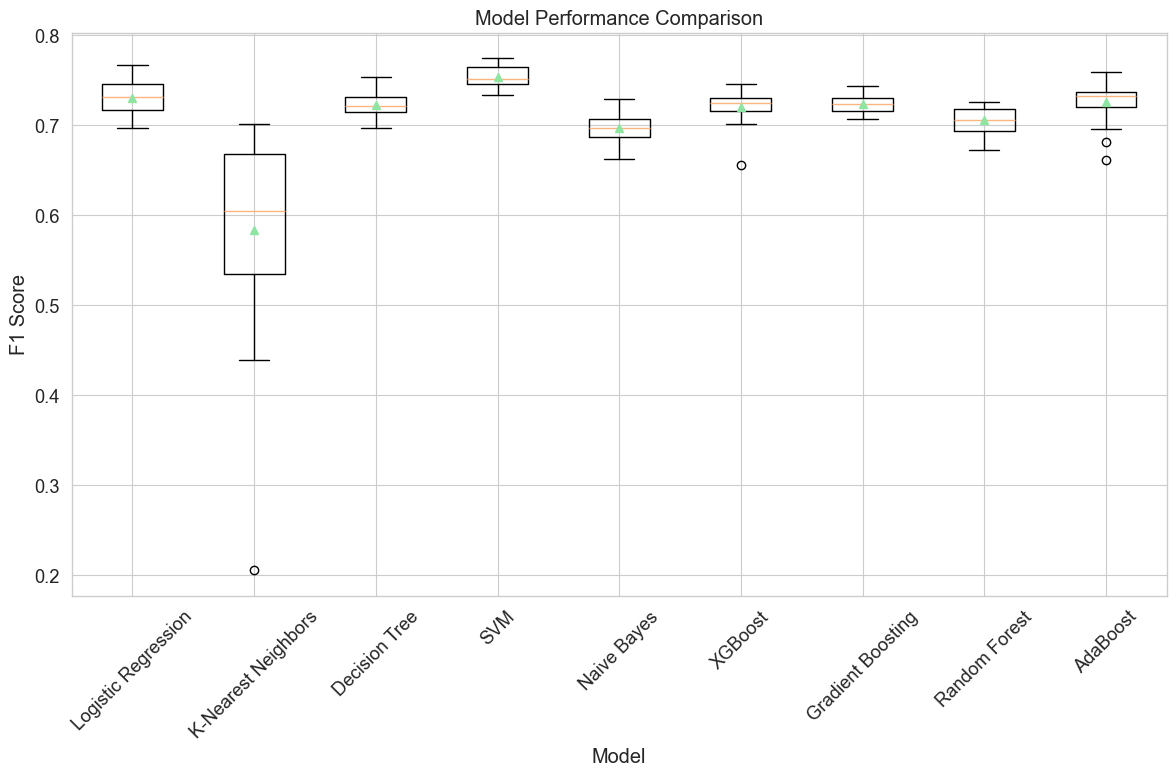

In [11]:
# Plotting model performance for comparison using boxplot
plt.figure(figsize=(12, 8))
plt.boxplot(results, labels=names, showmeans=True)
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

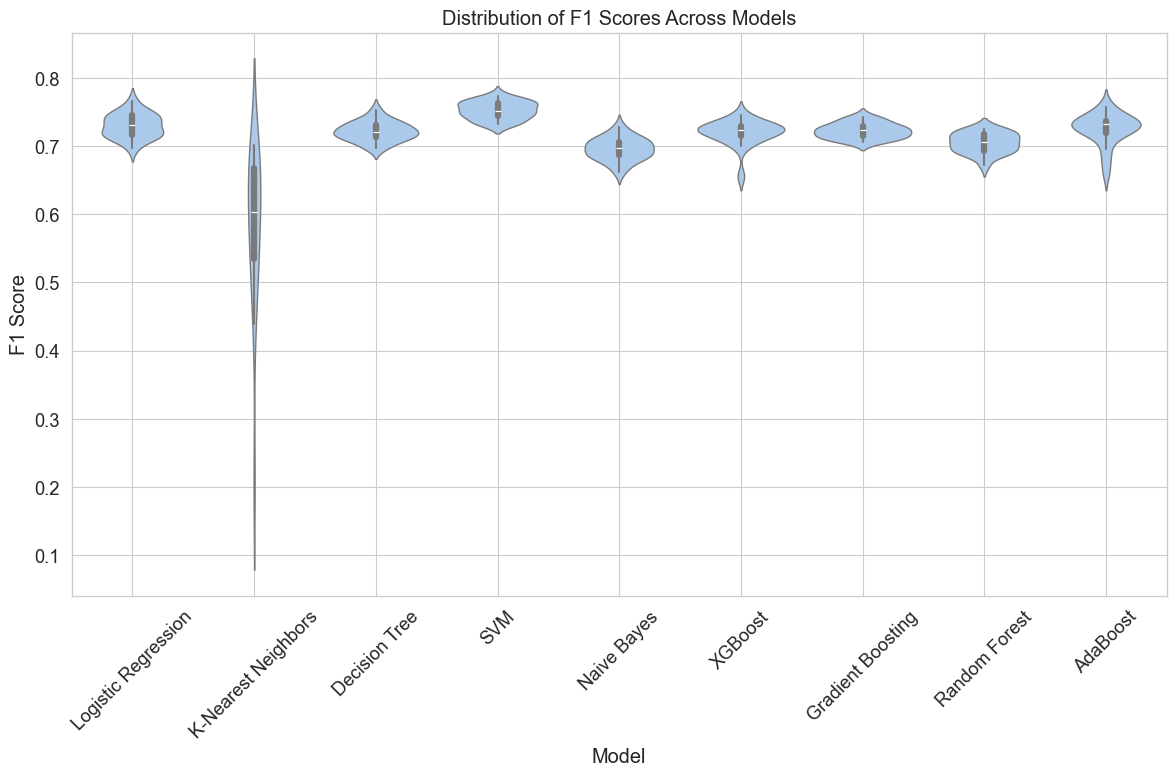

In [12]:
# Create a DataFrame for plotting
data = pd.DataFrame(data={name: scores for name, scores in zip(names, results)})
# Melt the DataFrame for easier plotting with seaborn
data_melted = data.melt(var_name='Model', value_name='F1 Score')

# Create the violin plot
plt.figure(figsize=(12, 8))  # Optional: Adjust the figure size as needed
sns.violinplot(x='Model', y='F1 Score', data=data_melted)
plt.title('Distribution of F1 Scores Across Models')  # Add a title to the plot
plt.xticks(rotation=45)  # Rotate model names for better visibility
plt.xlabel('Model')  # Label for the x-axis
plt.ylabel('F1 Score')  # Label for the y-axis
plt.grid(True)  # Optional: Add a grid for better readability
plt.tight_layout()  # Adjust layout to fit everything neatly
plt.show()